In [1]:
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf

In [2]:
print("Is GPU available?", tf.test.is_gpu_available())
print("TF version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available? True
TF version: 2.3.1
Keras version: 2.4.0


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random
import gym

In [4]:
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.f1 = tf.keras.layers.Dense(512, activation='relu')
        self.f2 = tf.keras.layers.Dense(512, activation='relu')
        self.v =  tf.keras.layers.Dense(1, activation=None)

    def call(self, inputstate, action):
        x = self.f1(tf.concat([inputstate, action], axis=1))
        x = self.f2(x)
        x = self.v(x)
        return x


class Actor(tf.keras.Model):
    def __init__(self, no_action):
        super(Actor, self).__init__()    
        self.f1 = tf.keras.layers.Dense(512, activation='relu')
        self.f2 = tf.keras.layers.Dense(512, activation='relu')
        self.mu =  tf.keras.layers.Dense(no_action, activation='tanh')

    def call(self, state):
        x = self.f1(state)
        x = self.f2(x)
        x = self.mu(x)  
        return x

In [5]:
class Agent():
    def __init__(self, n_actions, min_action, max_action):
        self.actor_main = Actor(n_actions)
        self.actor_target = Actor(n_actions)
        self.critic_main = Critic()
        self.critic_main2 = Critic()
        self.critic_target = Critic()
        self.critic_target2 = Critic()
        self.batch_size = 64
        self.n_actions = n_actions
        self.a_opt = tf.keras.optimizers.Adam(0.001)
        self.c_opt1 = tf.keras.optimizers.Adam(0.002)
        self.c_opt2 = tf.keras.optimizers.Adam(0.002)
        #self.memory = RBuffer(1_00_000, (8, ), 2)
        self.memory = deque(maxlen=100000)
        self.trainstep = 0
        self.gamma = 0.99
        self.min_action = min_action
        self.max_action = max_action
        self.actor_update_steps = 2
        self.warmup = 200
        self.actor_target.compile(optimizer=self.a_opt)
        self.critic_target.compile(optimizer=self.c_opt1)
        self.critic_target2.compile(optimizer=self.c_opt2)
        self.tau = 0.005


    def act(self, state, evaluate=False):
        if self.trainstep > self.warmup:
            evaluate = True
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor_main(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=0.1)

        actions = self.max_action * (tf.clip_by_value(actions, self.min_action, self.max_action))
        
        return actions[0]
    
    def store(self, state, action, reward, n_state, done):
        pack = [state, action, reward, n_state, 1 - int(done)]
        self.memory.append(pack)
    
    def take_data(self, batch_size):
        pack = random.sample(self.memory, batch_size)
        states = []
        actions = []
        rewards = []
        n_states = []
        dones = []
        for i in range(batch_size):
            states.append(pack[i][0])
            actions.append(pack[i][1])
            rewards.append(pack[i][2])
            n_states.append(pack[i][3])
            dones.append(pack[i][4])
        return states, actions, rewards, n_states, dones

    def update_target(self, tau=None):

        if tau is None:
            tau = self.tau

        weights1 = []
        targets1 = self.actor_target.weights
        for i, weight in enumerate(self.actor_main.weights):
            weights1.append(weight * tau + targets1[i]*(1-tau))
        self.actor_target.set_weights(weights1)

        weights2 = []
        targets2 = self.critic_target.weights
        for i, weight in enumerate(self.critic_main.weights):
            weights2.append(weight * tau + targets2[i]*(1-tau))
        self.critic_target.set_weights(weights2)


        weights3 = []
        targets3 = self.critic_target2.weights
        for i, weight in enumerate(self.critic_main2.weights):
            weights3.append(weight * tau + targets3[i]*(1-tau))
        self.critic_target2.set_weights(weights3)
    
    def upgrade(self):
        if len(self.memory) < 2*self.batch_size:
            return 


        states, actions, rewards, n_states, dones = self.take_data(self.batch_size)

        states = tf.convert_to_tensor(states, dtype= tf.float32)
        n_states = tf.convert_to_tensor(n_states, dtype= tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype= tf.float32)
        actions = tf.convert_to_tensor(actions, dtype= tf.float32)

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:

            target_actions = self.actor_target(n_states)
            target_actions += tf.clip_by_value(tf.random.normal(shape=[*np.shape(target_actions)], mean=0.0, stddev=0.2), -0.5, 0.5)
            target_actions = self.max_action * (tf.clip_by_value(target_actions, self.min_action, self.max_action))


            target_next_state_values = tf.squeeze(self.critic_target(n_states, target_actions), 1)
            target_next_state_values2 = tf.squeeze(self.critic_target2(n_states, target_actions), 1)

            critic_value = tf.squeeze(self.critic_main(states, actions), 1)
            critic_value2 = tf.squeeze(self.critic_main2(states, actions), 1)

            next_state_target_value = tf.math.minimum(target_next_state_values, target_next_state_values2)

            target_values = rewards + self.gamma * next_state_target_value * dones
            critic_loss1 = tf.keras.losses.MSE(target_values, critic_value)
            critic_loss2 = tf.keras.losses.MSE(target_values, critic_value2)




        grads1 = tape1.gradient(critic_loss1, self.critic_main.trainable_variables)
        grads2 = tape2.gradient(critic_loss2, self.critic_main2.trainable_variables)

        self.c_opt1.apply_gradients(zip(grads1, self.critic_main.trainable_variables))
        self.c_opt2.apply_gradients(zip(grads2, self.critic_main2.trainable_variables))


        self.trainstep +=1

        if self.trainstep % self.actor_update_steps == 0:

            with tf.GradientTape() as tape3:

                new_policy_actions = self.actor_main(states)
                actor_loss = -self.critic_main(states, new_policy_actions)
                actor_loss = tf.math.reduce_mean(actor_loss)

            grads3 = tape3.gradient(actor_loss, self.actor_main.trainable_variables)
            self.a_opt.apply_gradients(zip(grads3, self.actor_main.trainable_variables))

        self.update_target()

In [6]:
env = gym.make('LunarLanderContinuous-v2')

print('Min_action:', env.action_space.low[0])
print('Max_action: ', env.action_space.high[0])
print('States: ', env.observation_space.shape)
print('Actions: ', env.action_space.shape)

Min_action: -1.0
Max_action:  1.0
States:  (8,)
Actions:  (2,)


In [7]:
agent = Agent(2, -1, 1)

n_episodes = 2000
avg_hist = []
scores = []

for i in range(n_episodes):
    score = 0 
    state = env.reset()
    done = False

    while not done:
        action = agent.act(state)
        n_state, reward, done, _ = env.step(action)
        agent.store(state, action, reward, n_state, done)
        agent.upgrade()
        state = n_state
        score += reward
    
    scores.append(score)
    avg_reward = int(np.mean(scores[-100:]))
    avg_hist.append(avg_reward)
    print(f'Episode: {i}  Score: {score}  AVG: {avg_reward}')
    
    if avg_reward >= 210:
        break

env.close()

Episode: 0  Score: -205.19715702029288  AVG: -205
Episode: 1  Score: -882.1877978697755  AVG: -543
Episode: 2  Score: -920.1656213731746  AVG: -669
Episode: 3  Score: -754.098412605455  AVG: -690
Episode: 4  Score: -835.4873967603651  AVG: -719
Episode: 5  Score: -768.1555652195023  AVG: -727
Episode: 6  Score: -853.8424831558689  AVG: -745
Episode: 7  Score: -783.8791148603852  AVG: -750
Episode: 8  Score: -1408.3227984309206  AVG: -823
Episode: 9  Score: -796.9100460759269  AVG: -820
Episode: 10  Score: -793.4321412192994  AVG: -818
Episode: 11  Score: -781.7380009516306  AVG: -815
Episode: 12  Score: -769.2923645286625  AVG: -811
Episode: 13  Score: -1296.2659185152852  AVG: -846
Episode: 14  Score: -1713.0055952743974  AVG: -904
Episode: 15  Score: -2324.0399331910917  AVG: -992
Episode: 16  Score: -907.624074283217  AVG: -987
Episode: 17  Score: -848.7271192803784  AVG: -980
Episode: 18  Score: -1118.9136805841035  AVG: -987
Episode: 19  Score: -737.9384552951708  AVG: -974
Episod

Episode: 162  Score: -86.15994683651968  AVG: -133
Episode: 163  Score: -26.35176441600788  AVG: -132
Episode: 164  Score: -56.46506325027233  AVG: -132
Episode: 165  Score: 58.74652876191943  AVG: -131
Episode: 166  Score: 17.359276441139237  AVG: -129
Episode: 167  Score: 173.87588625863233  AVG: -127
Episode: 168  Score: -49.179415269405354  AVG: -126
Episode: 169  Score: 45.004304628904414  AVG: -129
Episode: 170  Score: 206.36459110266657  AVG: -124
Episode: 171  Score: 200.6496190496211  AVG: -119
Episode: 172  Score: -40.28542355623159  AVG: -116
Episode: 173  Score: -46.20578875810105  AVG: -114
Episode: 174  Score: -21.084568062247833  AVG: -113
Episode: 175  Score: 9.965259488400312  AVG: -111
Episode: 176  Score: -36.71660202692868  AVG: -111
Episode: 177  Score: -21.399065425118287  AVG: -110
Episode: 178  Score: -99.17549796629469  AVG: -109
Episode: 179  Score: -63.01547275599075  AVG: -110
Episode: 180  Score: 237.6664246721131  AVG: -106
Episode: 181  Score: -13.4506438

Text(0, 0.5, 'Avg rewards')

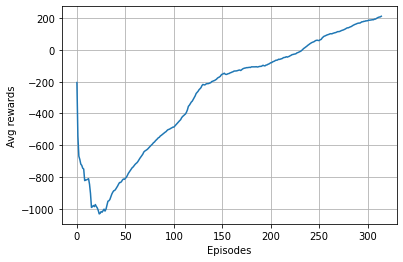

In [8]:
plt.plot(avg_hist)
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Avg rewards')

In [9]:
env = gym.make('LunarLanderContinuous-v2')

for i in range(10):
    state = env.reset()
    done = False
    
    while not done:
        action = agent.act(state, True)
        n_state, _, done, _ = env.step(action)
        state = n_state
        env.render()
env.close()

In [10]:
agent.actor_main.save_weights('actor_weights.h5')